In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./input/classification_validation_data.npz
./input/sample_submission.csv
./input/classification_test_data.npz
./input/classification_training_data.npz
./input/g2net-hackathon.zip


In [3]:
import numpy as np
import pandas as pd
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, Adamax, AdamW
from torch import nn
from torchmetrics.classification.accuracy import MulticlassAccuracy

import pylab

In [4]:
torch.manual_seed(113)
np.random.seed(1)

In [5]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(0)

In [6]:
class WaveformDataset(Dataset):
    def __init__(self, npz_file, test=False):
        df = np.load(npz_file)
        self.foregrounds = df['foreground']
        self.n_samples = self.foregrounds.shape[0]
        print(f'Total number of samples: {self.n_samples}')
        self.test = test
        if not self.test:
            # we don't have labels available for the test set
            self.labels = df['label'][:self.n_samples]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, item):
        fg = np.asarray(self.foregrounds[item, :])
        if self.test:
            return torch.from_numpy(fg)

        label = np.asarray(self.labels[item])
        return torch.from_numpy(fg), label

train_dataset = WaveformDataset('./input/classification_training_data.npz')
val_dataset = WaveformDataset('./input/classification_validation_data.npz')

Total number of samples: 10000
Total number of samples: 2000


In [7]:
network = nn.Sequential(  # Shapes
    nn.BatchNorm1d(1),  # 1x2048
    nn.Conv1d(1, 4, 64),  # 4x1985
    nn.ELU(),  # 4x1985
    nn.Conv1d(4, 4, 32),  # 4x1954
    nn.MaxPool1d(4),  # 4x 489
    nn.ELU(),  # 4x 489
    nn.Conv1d(4, 8, 32),  # 8x 458
    nn.ELU(),  # 8x 458
    nn.Conv1d(8, 8, 16),  # 8x 443
    nn.MaxPool1d(3),  # 8x 147
    nn.ELU(),  # 8x 147
    nn.Conv1d(8, 16, 16),  # 16x 132
    nn.ELU(),  # 16x 132
    nn.Conv1d(16, 16, 16),  # 16x 117
    nn.MaxPool1d(4),  # 16x  29
    nn.ELU(),  # 16x  29
    nn.Flatten(),  # 464
    nn.Linear(464, 32),  # 32
    nn.Dropout(p=0.5),  # 32
    nn.ELU(),  # 32
    nn.Linear(32, 16),  # 16
    nn.Dropout(p=0.5),  # 16
    nn.ELU(),  # 16
    nn.Linear(16, 3),  # 2
    nn.Softmax(dim=1)  # 2
)
print(network)
# HINT: https://pytorch.org/docs/stable/nn.init.html
# https://stackoverflow.com/a/49433937

Sequential(
  (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv1d(1, 4, kernel_size=(64,), stride=(1,))
  (2): ELU(alpha=1.0)
  (3): Conv1d(4, 4, kernel_size=(32,), stride=(1,))
  (4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (5): ELU(alpha=1.0)
  (6): Conv1d(4, 8, kernel_size=(32,), stride=(1,))
  (7): ELU(alpha=1.0)
  (8): Conv1d(8, 8, kernel_size=(16,), stride=(1,))
  (9): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (10): ELU(alpha=1.0)
  (11): Conv1d(8, 16, kernel_size=(16,), stride=(1,))
  (12): ELU(alpha=1.0)
  (13): Conv1d(16, 16, kernel_size=(16,), stride=(1,))
  (14): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (15): ELU(alpha=1.0)
  (16): Flatten(start_dim=1, end_dim=-1)
  (17): Linear(in_features=464, out_features=32, bias=True)
  (18): Dropout(p=0.5, inplace=False)
  (19): ELU(alpha=1.0)
  (20): Linear(in_features=32, out_featur

In [8]:
device = 'cuda:0'
device = 'cpu'
network = network.to(device)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=device)
val_dataloader = DataLoader(val_dataset, batch_size=128, num_workers=2, pin_memory=device)
n_epochs = 10
lr = 5e-5
optimizer = Adam(network.parameters(), lr=lr)
# HINT: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html
loss = nn.CrossEntropyLoss()

train_losses = np.zeros((n_epochs,))
train_accs = np.zeros((n_epochs,))
val_losses = np.zeros((n_epochs,))
val_accs = np.zeros((n_epochs,))

acc_metric = MulticlassAccuracy(num_classes=3, average='none').to(device)


learn_rates = [5e-5,5e-3,5e-2,5e-1]
optimizers= [ Adam, Adamax, SGD, AdamW]

learn_rates = [5e-5]
optimizers= [ Adam]

Epoch 0 | Training   | Loss 1.10 | Acc 34.86% 
Epoch 0 | Validation | Loss 1.10 | Acc 34.65% (0: 1.00 1: 0.00 2: 0.00)
Epoch 1 | Training   | Loss 1.10 | Acc 36.05% 
Epoch 1 | Validation | Loss 1.10 | Acc 34.65% (0: 1.00 1: 0.00 2: 0.00)
Epoch 2 | Training   | Loss 1.10 | Acc 37.18% 
Epoch 2 | Validation | Loss 1.09 | Acc 41.80% (0: 1.00 1: 0.00 2: 0.21)
Epoch 3 | Training   | Loss 0.99 | Acc 58.37% 
Epoch 3 | Validation | Loss 0.94 | Acc 58.85% (0: 0.74 1: 0.00 2: 0.94)
Epoch 4 | Training   | Loss 0.89 | Acc 65.63% 
Epoch 4 | Validation | Loss 0.85 | Acc 67.50% (0: 0.96 1: 0.19 2: 0.81)
Epoch 5 | Training   | Loss 0.86 | Acc 68.18% 
Epoch 5 | Validation | Loss 0.84 | Acc 71.15% (0: 0.86 1: 0.35 2: 0.88)
Epoch 6 | Training   | Loss 0.85 | Acc 69.51% 
Epoch 6 | Validation | Loss 0.82 | Acc 72.40% (0: 0.90 1: 0.43 2: 0.81)
Epoch 7 | Training   | Loss 0.85 | Acc 70.59% 
Epoch 7 | Validation | Loss 0.85 | Acc 69.75% (0: 0.78 1: 0.37 2: 0.90)
Epoch 8 | Training   | Loss 0.83 | Acc 71.66% 
E

/work/francisco.jimenez/venv_sc/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


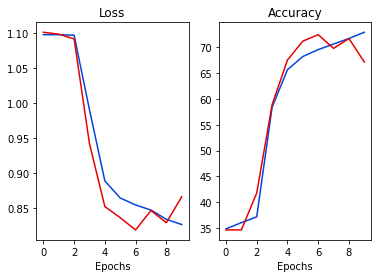

In [9]:
for k in learn_rates :
    for j in optimizers:
        optimizer = j(network.parameters(), lr=k)

        for ep in range(n_epochs):
            network.train()
            training_loss = 0.
            training_correct = 0
            training_total = 0
            for i, (x, y) in enumerate(train_dataloader):
                # unsqueeze is needed here to add a channel dimension so we can use convolutional layers
                x = x.unsqueeze_(1).to(dtype=torch.float32).to(device)
                y = y.to(dtype=torch.long).to(device)

                optimizer.zero_grad()

                p = network(x)
                l = loss(p, y)

                l.backward()
                # HINT: https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html
                optimizer.step()

                training_loss += l.item()
                # we need to convert the one-hot predictions into (0, 1, 2) labels to measure accuracy
                _, p_c = p.max(1)
                training_correct += p_c.eq(y).sum().item()
                training_total += x.size(0)

            train_losses[ep] = training_loss / (i + 1)
            train_accs[ep] = 100 * training_correct/training_total
            print(f'Epoch {ep} | Training   | Loss {train_losses[ep]:3.2f} |'
                  f' Acc {train_accs[ep]:5.2f}% ')

            network.eval()  # this line sets the network to evaluation mode (e.g., do not compute gradients, or mean and std for batch normalization layers)
            validation_loss = 0.
            validation_correct = 0.
            validation_total = 0.
            val_preds = []
            val_gt = []
            with torch.no_grad():
                for i, (x, y) in enumerate(val_dataloader):
                    x = x.unsqueeze_(1).to(dtype=torch.float32).to(device)
                    y = y.to(dtype=torch.long).to(device)
                    p = network(x)
                    l = loss(p, y)
                    # no backward pass for validation set
                    validation_loss += l.item()
                    _, p_c = p.max(1)
                    val_preds.extend(p_c)
                    val_gt.extend(y)
                    validation_correct += p_c.eq(y).sum().item()
                    validation_total += x.size(0)
                val_losses[ep] = validation_loss / (i + 1)
                val_accs[ep] = 100 * validation_correct / validation_total
                val_acc_per_class = acc_metric(torch.stack(val_preds), torch.stack(val_gt))
                print(f'Epoch {ep} | Validation | Loss {val_losses[ep]:3.2f} |'
                      f' Acc {val_accs[ep]:5.2f}% (0:{val_acc_per_class[0]:5.2f} 1:{val_acc_per_class[1]:5.2f} 2:{val_acc_per_class[2]:5.2f})')
    fig, axs = pylab.subplots(1, 2, sharex=True)
    axs[0].plot(train_losses, label='train', color='xkcd:blue')
    axs[0].plot(val_losses, label='val', color='xkcd:red')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')

    axs[1].plot(train_accs, label='train', color='xkcd:blue')
    axs[1].plot(val_accs, label='val', color='xkcd:red')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    
    print('Running network on test data...')
    test_dataset = WaveformDataset('./input/classification_test_data.npz', test=True)
    # IMPORTANT: do NOT shuffle test set
    test_dataloader = DataLoader(test_dataset, batch_size=128, num_workers=8, pin_memory=device, shuffle=False)
    network.eval()
    test_preds = []
    test_gt = []
    with torch.no_grad():
        for i, x in enumerate(test_dataloader):
            x = x.unsqueeze_(1).to(dtype=torch.float32).to(device)
            p = network(x)

            _, p_c = p.max(1)
            test_preds.extend(p_c.cpu().numpy())
    # write result to csv
    df = pd.DataFrame({'Category': np.asarray(test_preds)})
    df.index.name = 'Id'
    df.to_csv('classification_test_predictions_'+'_'+str(k)+'_'+j.__name__+'.csv')